# Telecom Churn Prediction - Starter Notebook

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
raw_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")
output = pd.read_csv("sample.csv")

#Checking the kaggle paths for the uploaded datasets
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [16]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

print(raw_data.shape)
print(test_data.shape)
print(output.shape)
print(data_dict.shape)

raw_data.head()

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


# 2. Exploratory Data Analysis
Let us first look at the data dictionary to understand the variables in the dataset.
We will then split the data set into categorical and numerical variables and perform EDA on each of them separately.

In [15]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


## 2.1. Categorical variables
We know that the categorical variables are the ones that are of type object. Let us look at the categorical variables in our dataset.
And we'll also get the numerical variables from the data set.

First thing however is to see if there are any missing values in the data set. We can use the missingno library to visualize the missing values in the data set.

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (172).

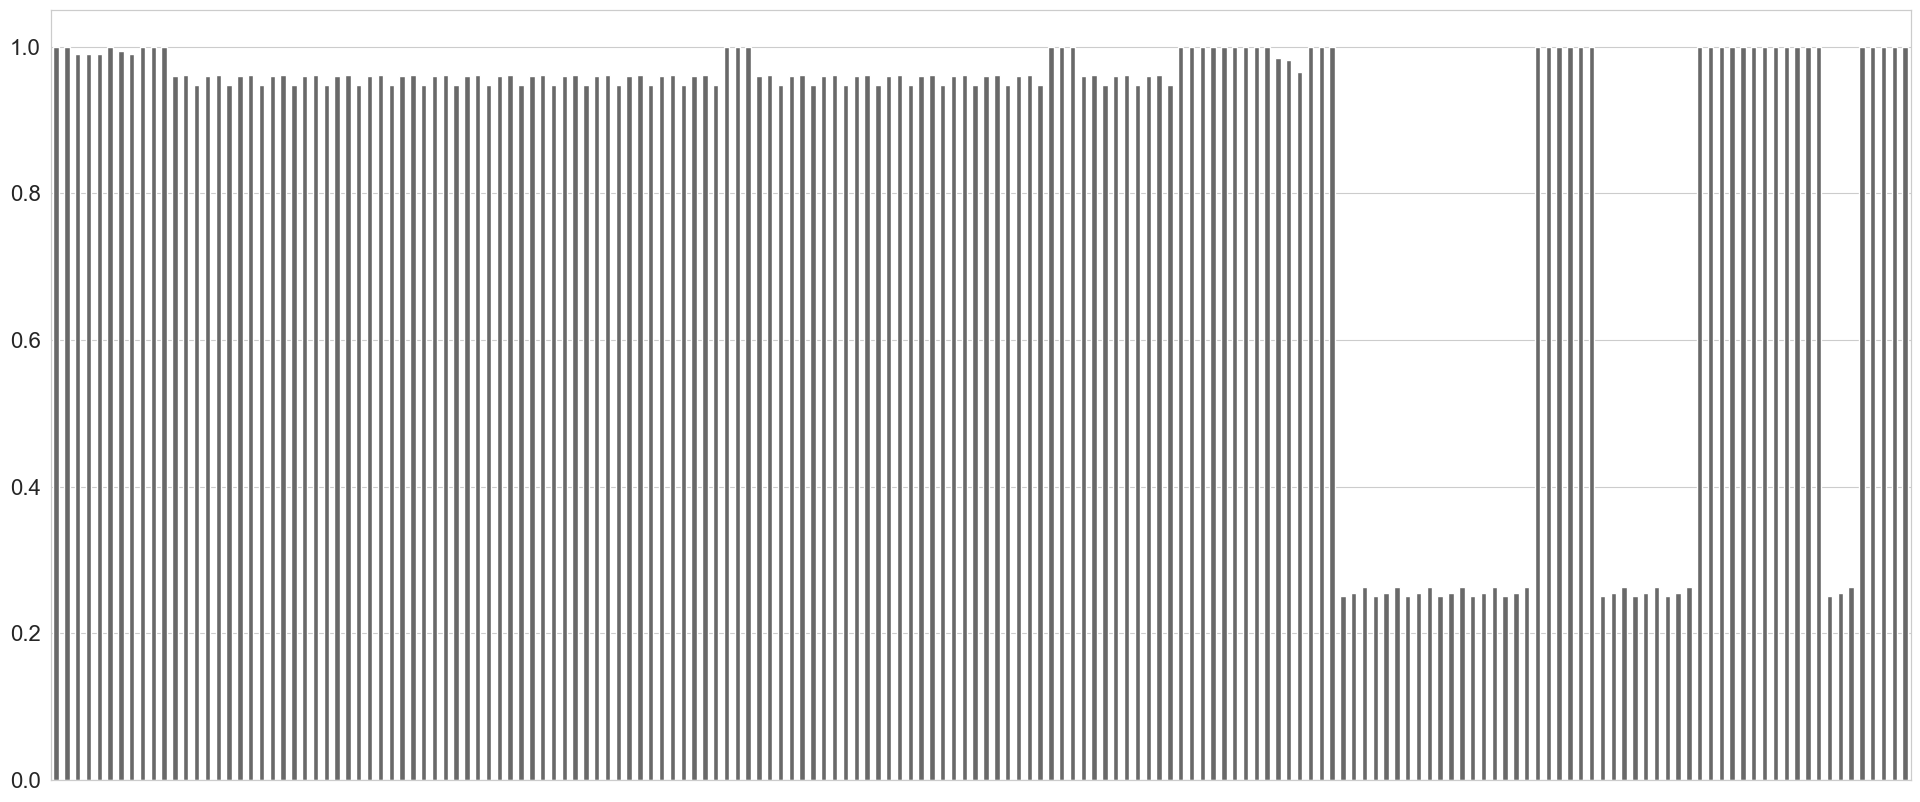

In [5]:
#Checking for missing values
msno.bar(raw_data)


In [7]:
# That suggests we have a lot of missing values in the data set. Let us look at the percentage of missing values in each column.
# We will only look at the columns that have missing values.
# Let us sort the columns by the percentage of missing values in each column in descending order.
raw_data.isnull().sum()[raw_data.isnull().sum()>0].sort_values(ascending=False)/raw_data.shape[0]*100 #Percentage of missing values in each column

max_rech_data_6             74.902499
fb_user_6                   74.902499
date_of_last_rech_data_6    74.902499
av_rech_amt_data_6          74.902499
night_pck_user_6            74.902499
                              ...    
last_date_of_month_8         1.047158
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
loc_og_t2o_mou               1.002871
last_date_of_month_7         0.570008
Length: 125, dtype: float64

In [8]:
# Let us look at the types of the columns with large number of missing values in the data set.
# Let us write a one liner to retrieve the name of the column and the associated type for all
# columns with any missing values
raw_data[raw_data.isnull().sum()[raw_data.isnull().sum()>0].index].dtypes


loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_7     object
last_date_of_month_8     object
                         ...   
night_pck_user_7        float64
night_pck_user_8        float64
fb_user_6               float64
fb_user_7               float64
fb_user_8               float64
Length: 125, dtype: object

In [10]:
# Let us split these columns into two sets, numerical and categorical and impute the missing values separately for each set.
numerical_columns_with_nan, categorical_columns_with_nan = [col for col in raw_data.columns[raw_data.isna().any()] if np.issubdtype(raw_data[col].dtype, np.number)], [col for col in raw_data.columns[raw_data.isna().any()] if pd.api.types.is_string_dtype(raw_data[col])]

print(numerical_columns_with_nan)
print(categorical_columns_with_nan)


['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_m

### 2.1.1. Categorical variables with missing values imputation
We seem to have a reasonably large number of categorical variables with missing values. Let us look at the percentage of missing values in each of these columns.


<Axes: >

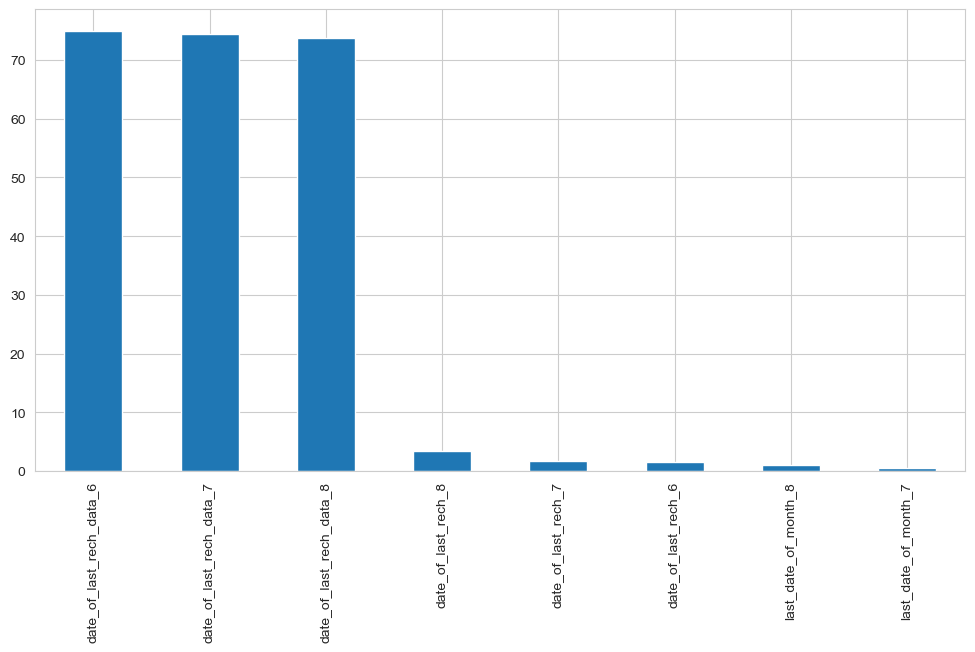

In [11]:
missing_values_percent = raw_data[categorical_columns_with_nan].isnull().mean() * 100
missing_values_percent.sort_values(ascending=False).plot.bar(figsize=(12,6))

In [17]:
# last date of the month can be imputed but these columns are of no consequence to us. So we can drop all columns that match the pattern last_date_of_month_*
raw_data = raw_data.drop(columns=raw_data.filter(regex='last_date_of_month_*').columns)
raw_data.shape

(69999, 169)

In [18]:
# In my opinion date of last recharge is irrelevant as the last recharge amounts are also available in the data set for each
# of the previous months. So we can drop all columns that match the pattern date_of_last_rech_*.
raw_data = raw_data.drop(columns=raw_data.filter(regex='date_of_last_rech_*').columns)
raw_data.shape

(69999, 163)

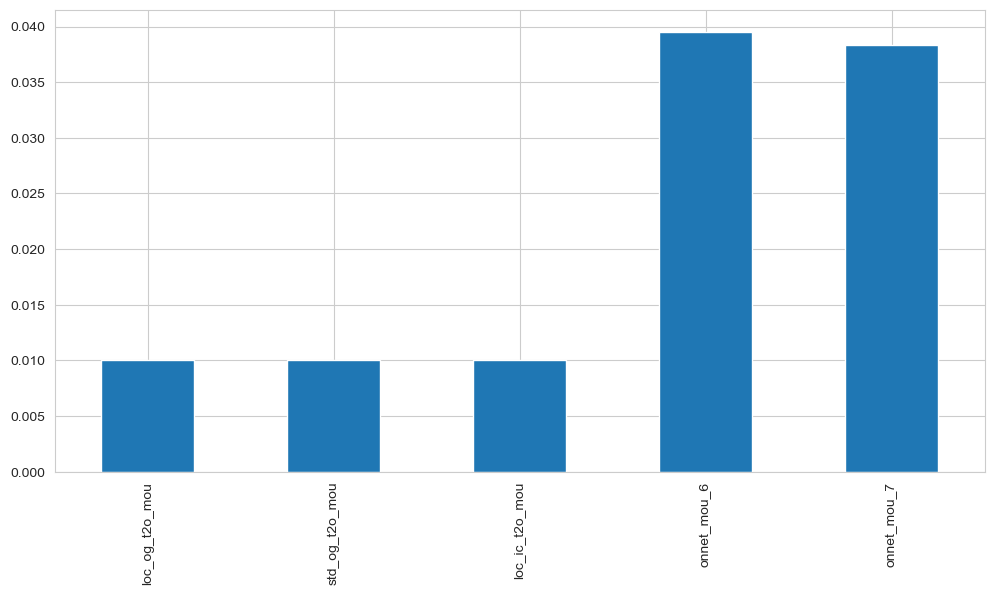

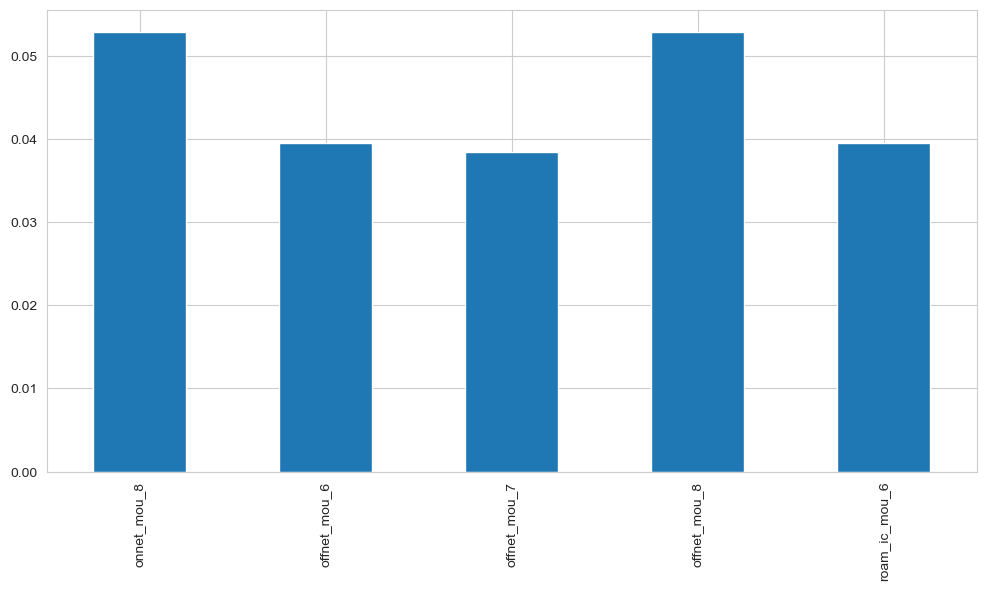

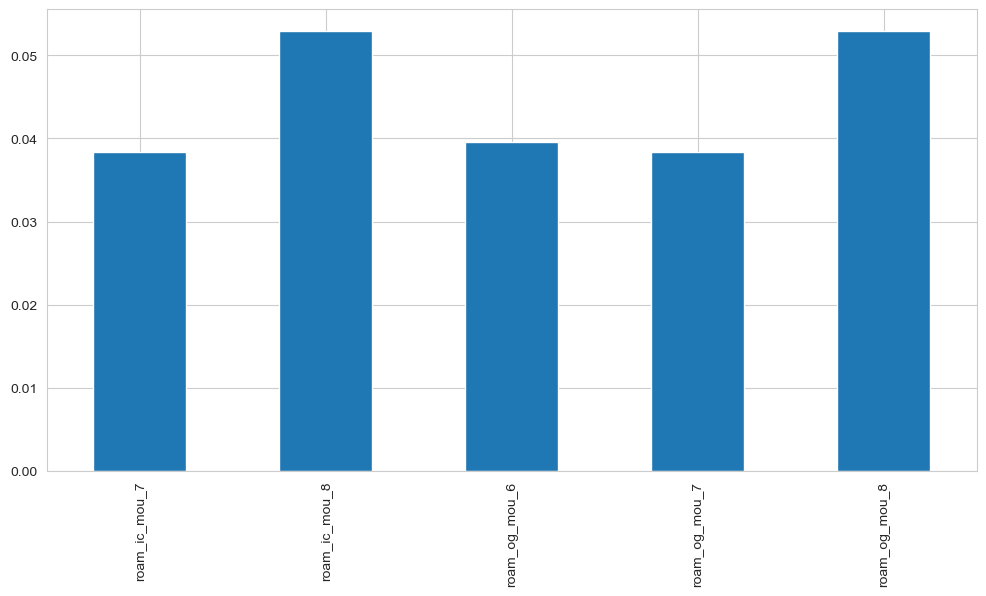

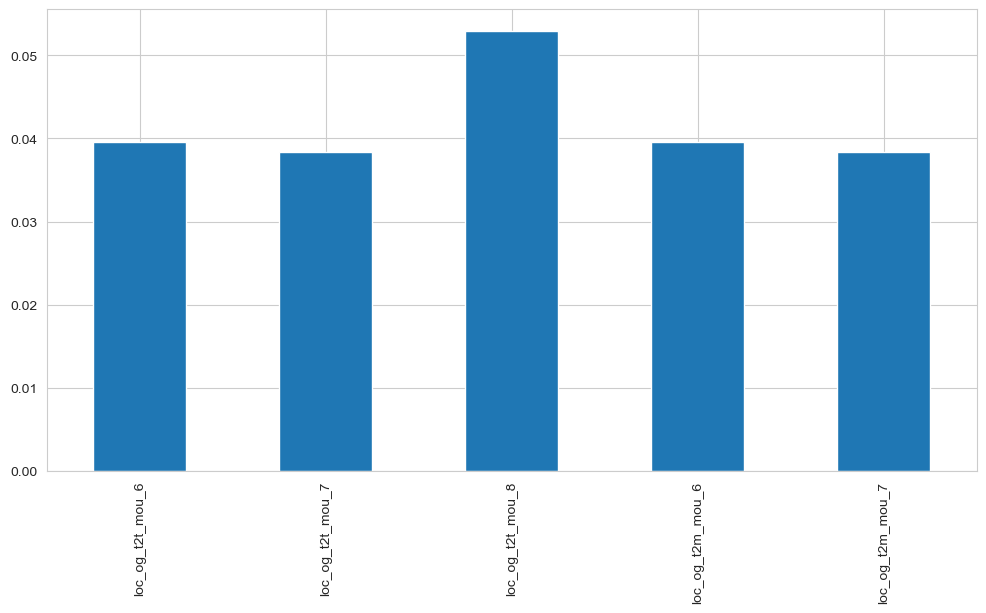

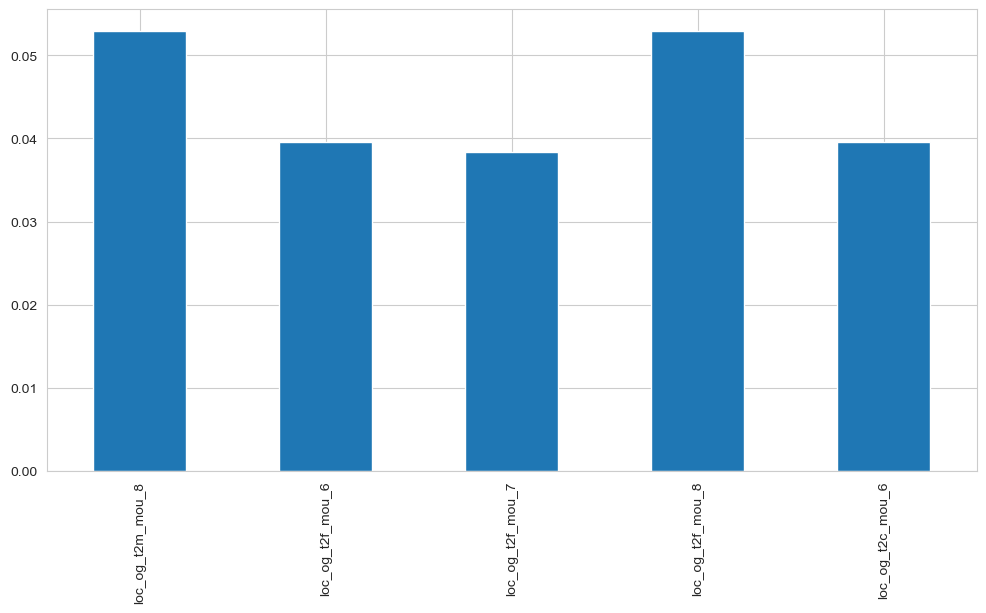

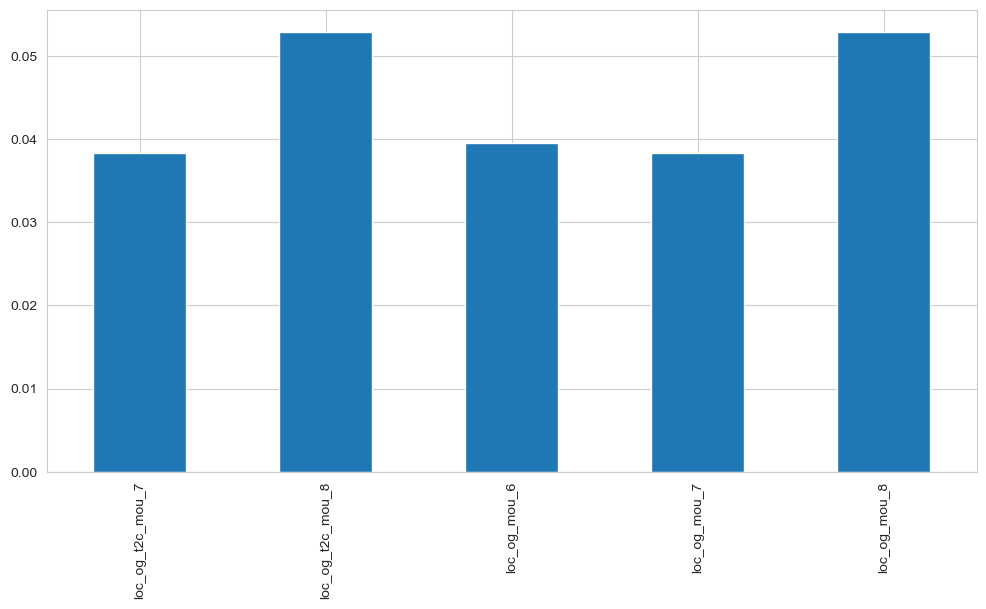

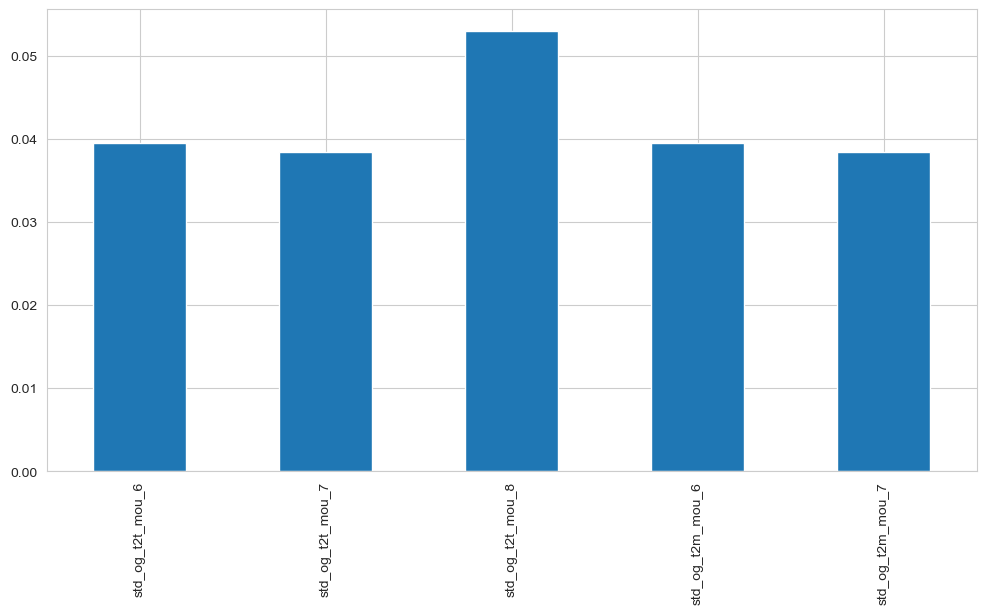

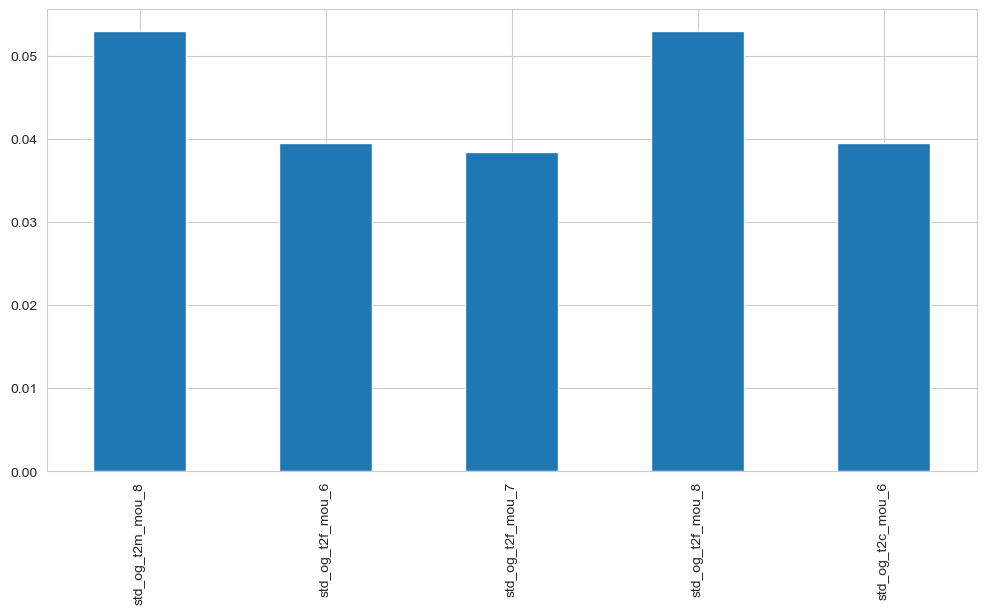

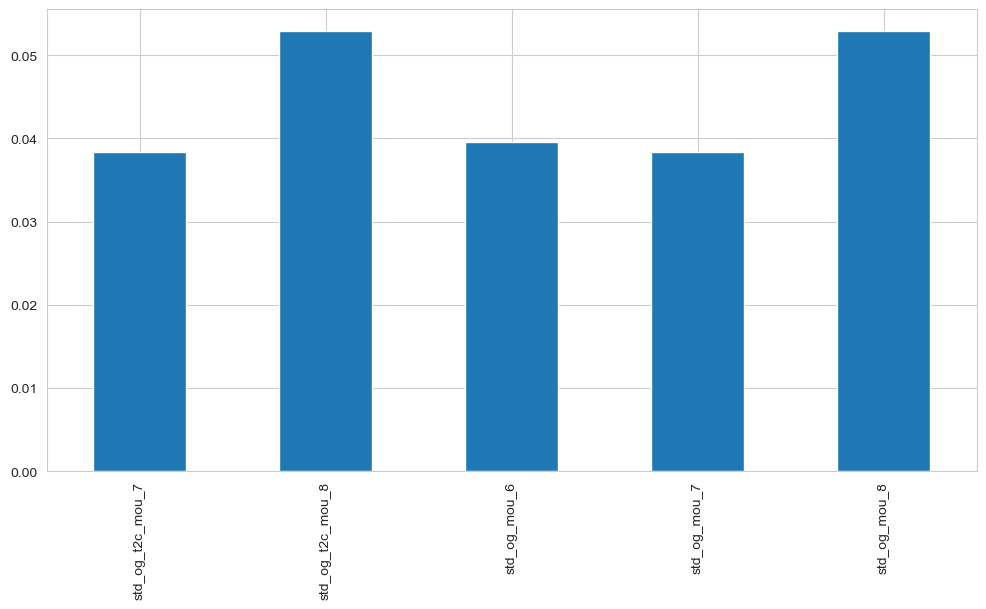

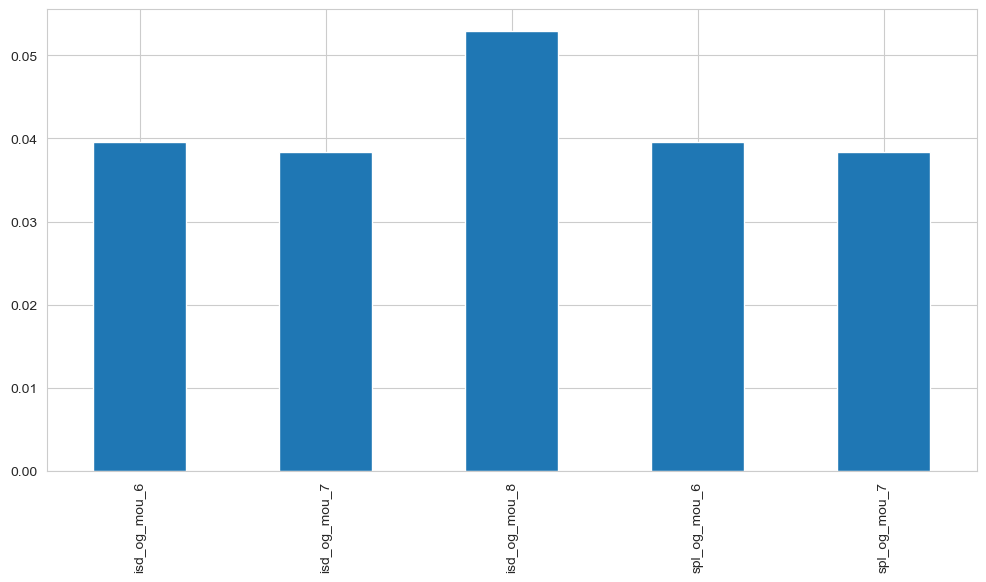

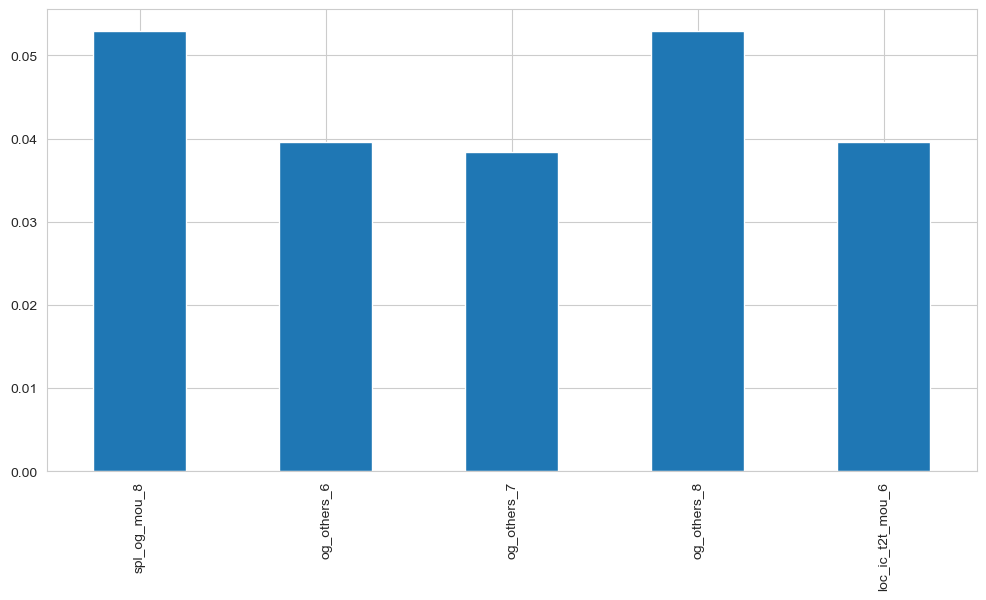

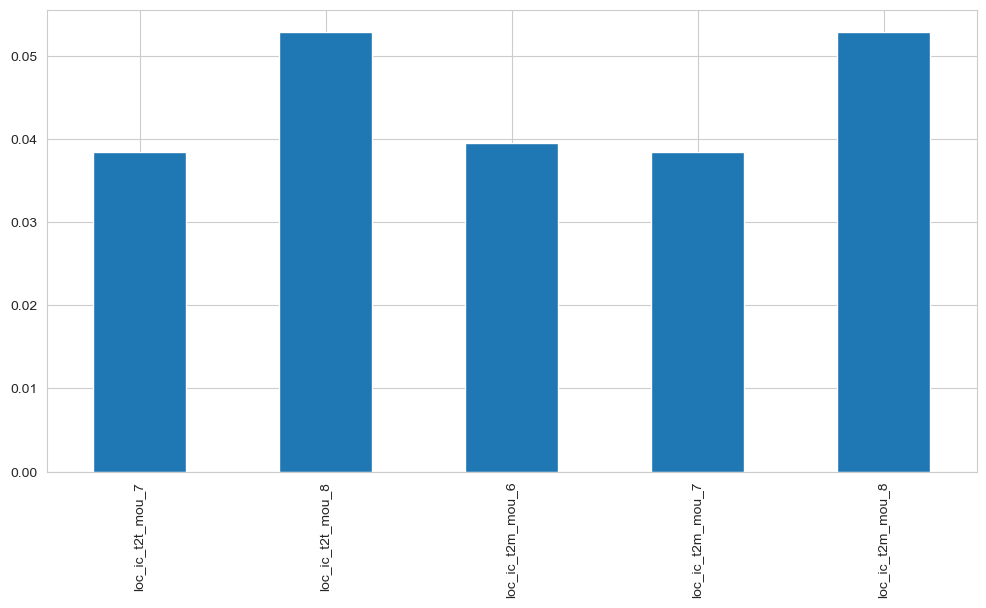

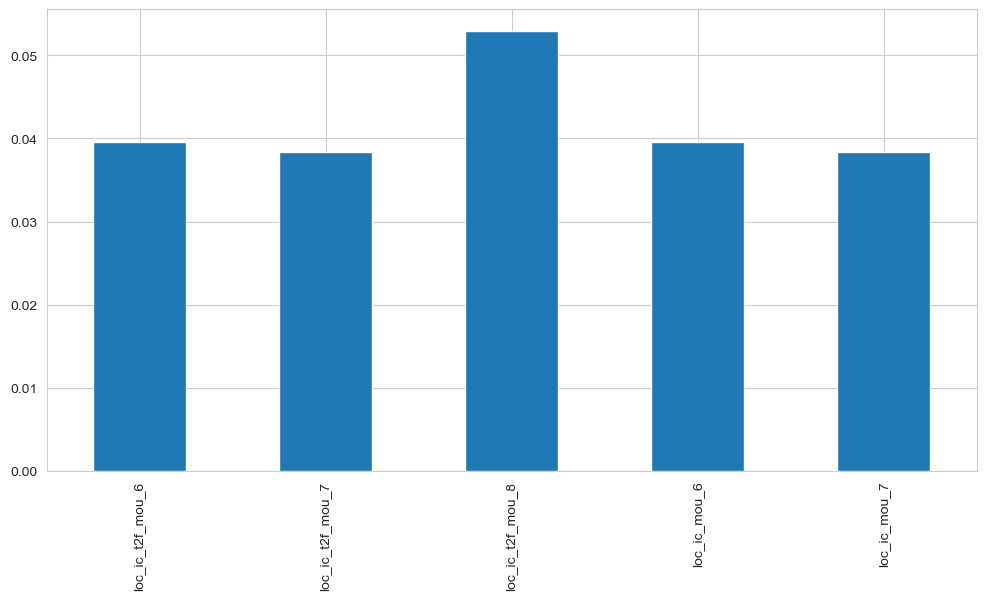

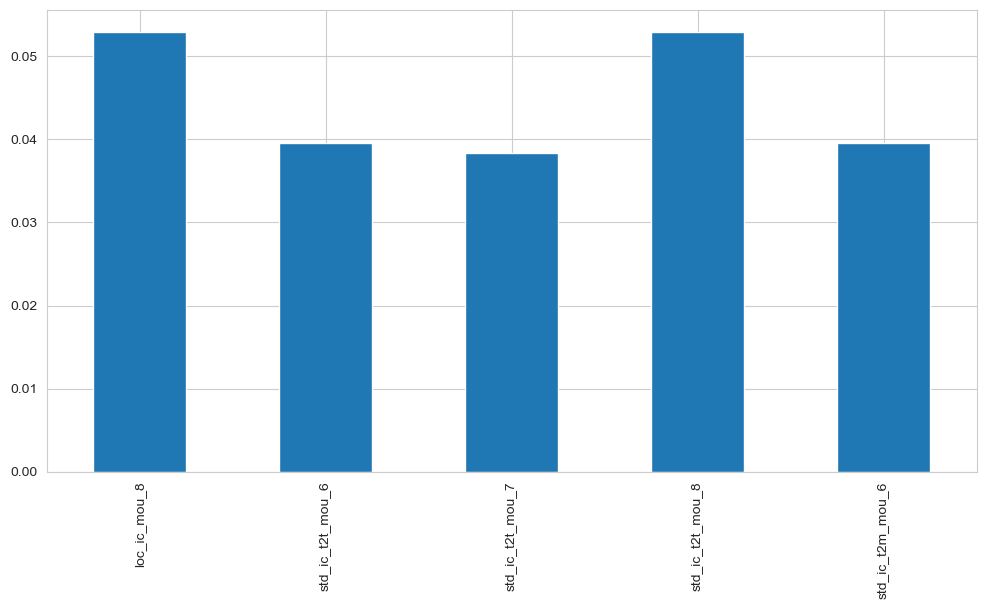

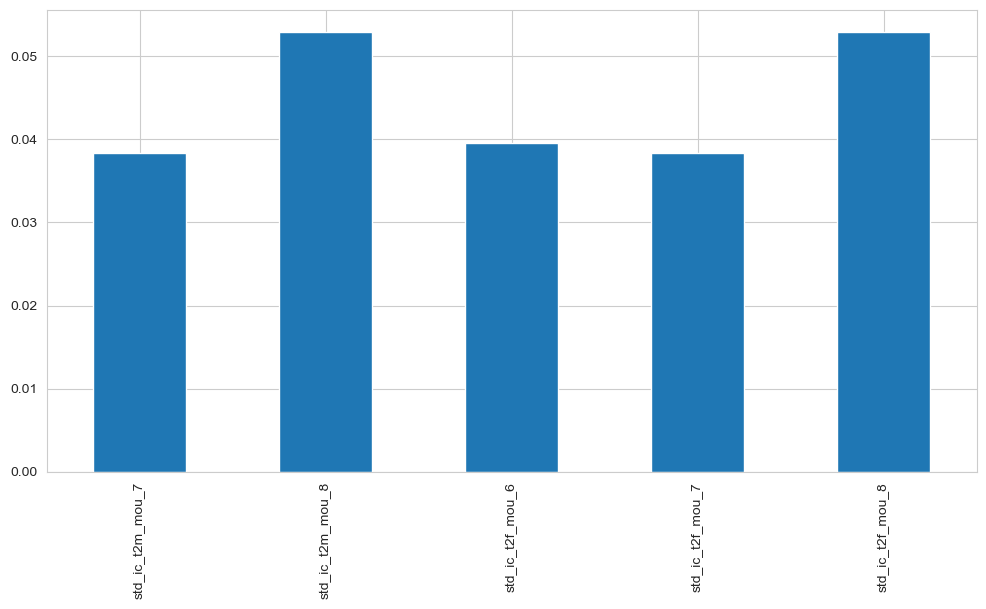

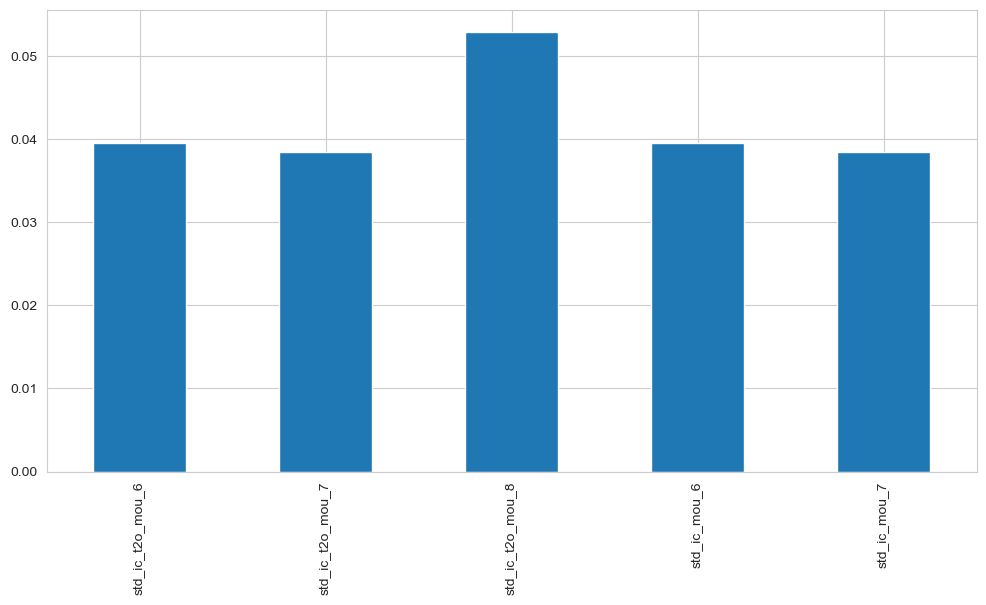

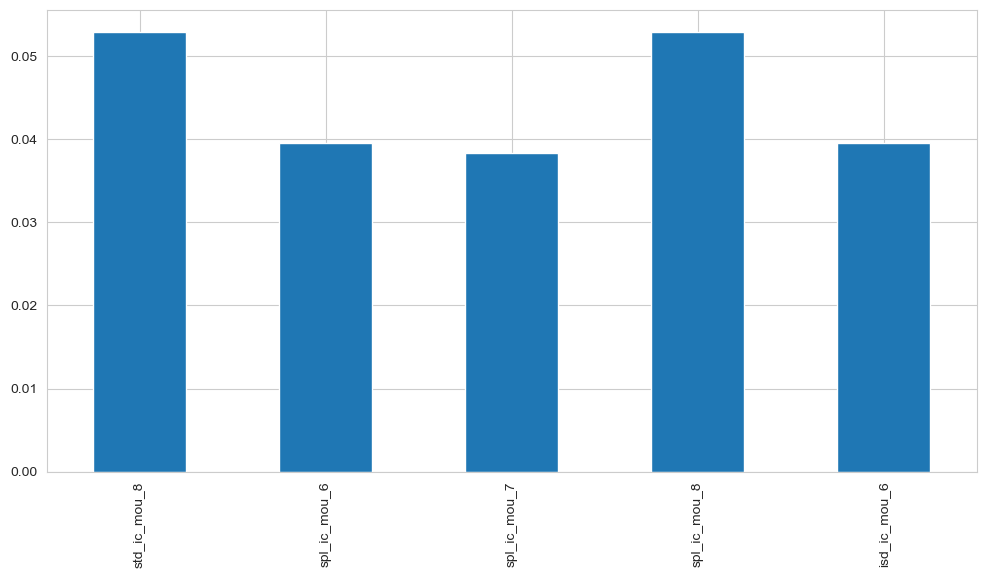

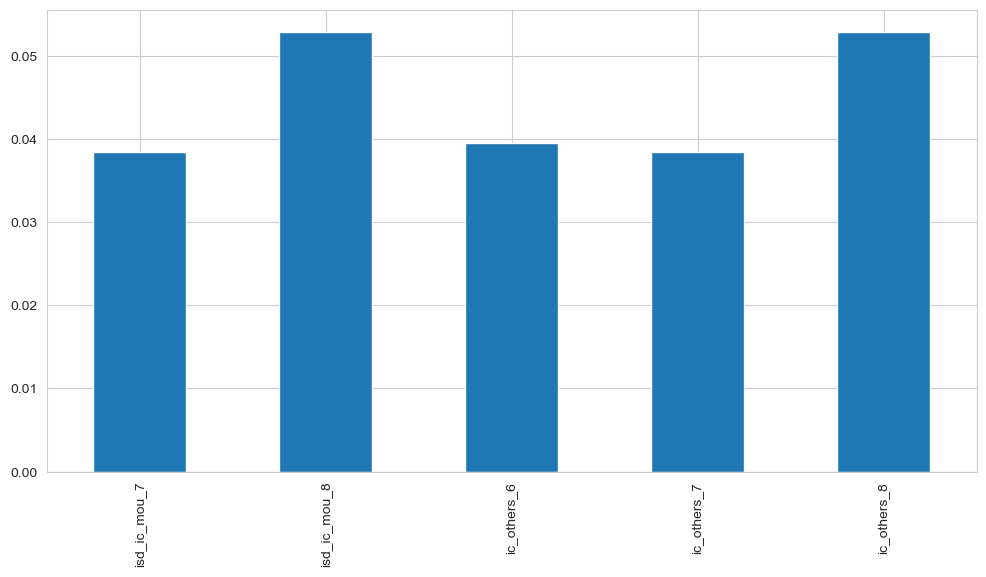

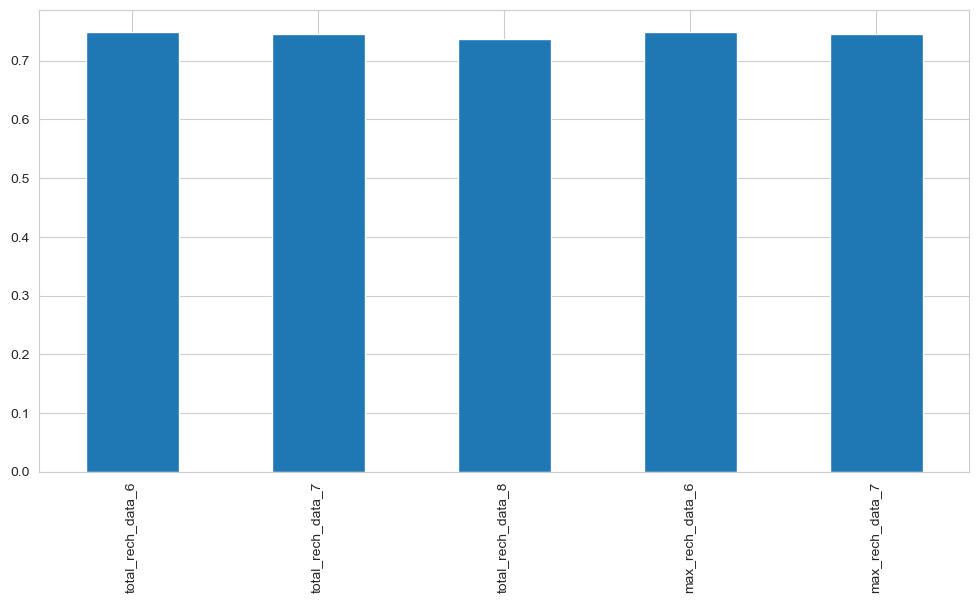

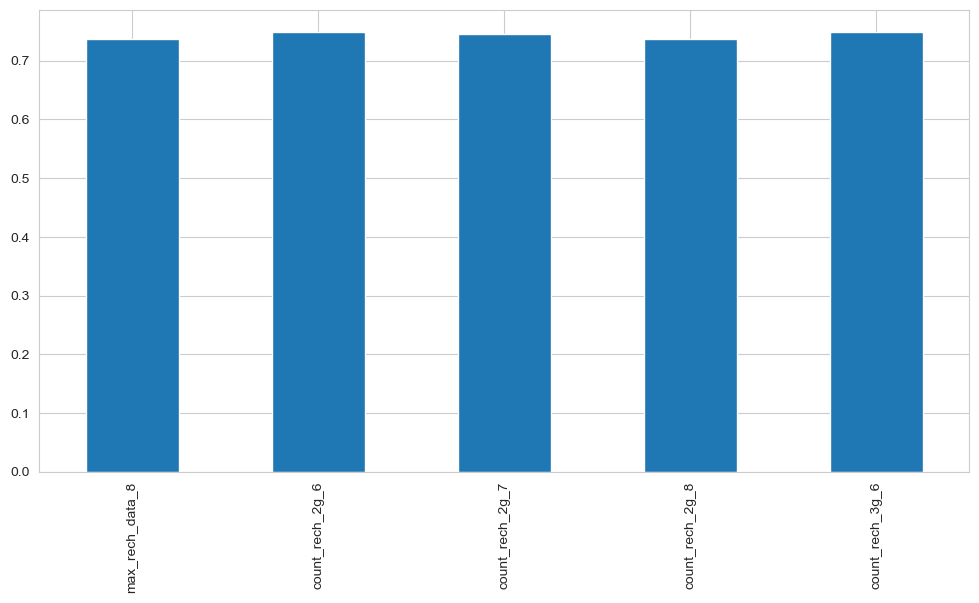

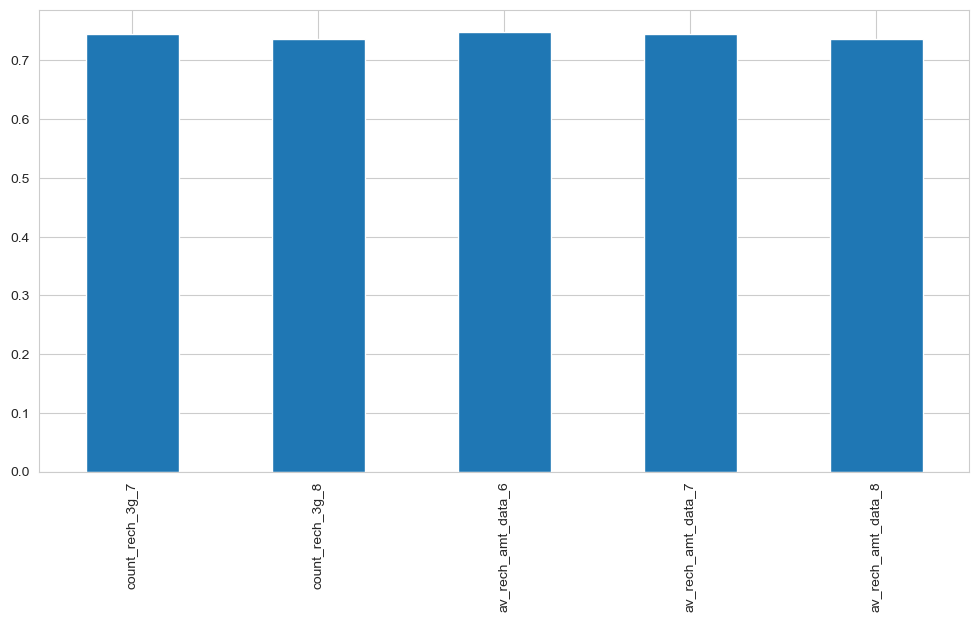

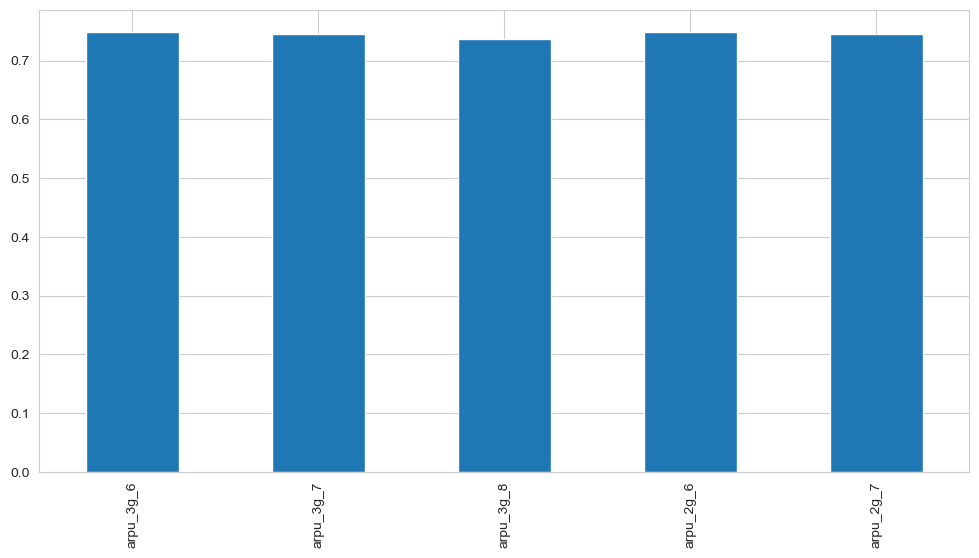

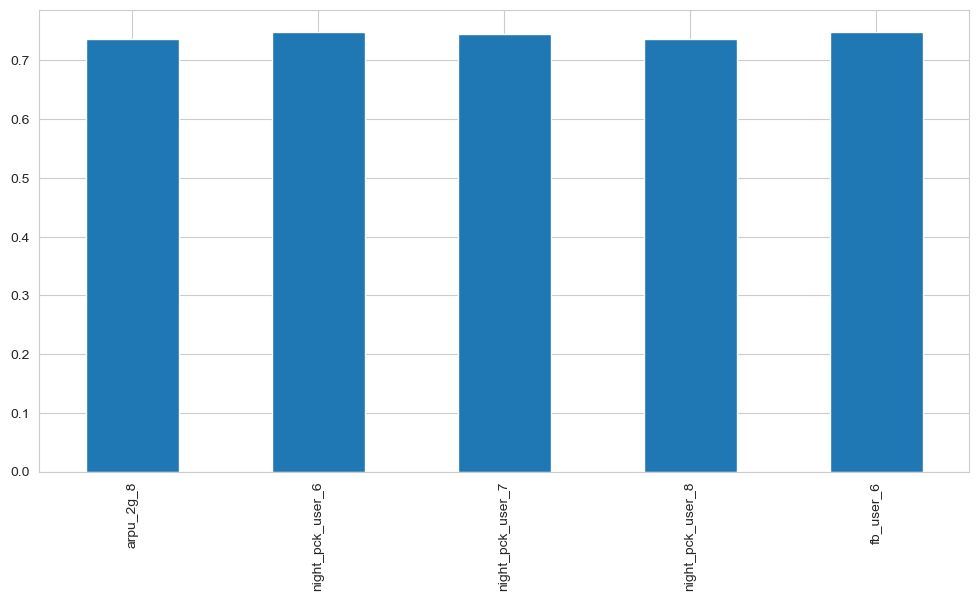

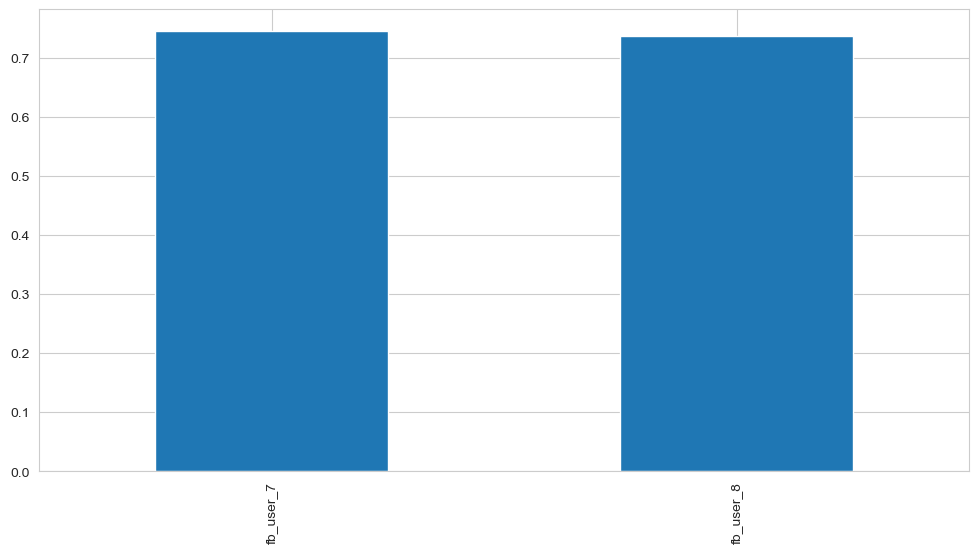

In [24]:
# At this point none of the categorical columns with missing values are in the data set.
# Let us look at the numerical columns with missing values given by the numerical_columns_with_nan variable.
# Let us plot a histogram of the missing values in each of these columns.
# Including 5 numerical columns per plot
for i in range(0,len(numerical_columns_with_nan),5):
    raw_data[numerical_columns_with_nan[i:i+5]].isnull().mean().plot.bar(figsize=(12,6))
    plt.show()

### 2.1.2. Numerical variables with missing values imputation
Since all the columns are either recharge related or usage related, we can impute the missing values with 0.

In [25]:
raw_data[numerical_columns_with_nan] = raw_data[numerical_columns_with_nan].fillna(0)
raw_data[numerical_columns_with_nan].isnull().sum()

loc_og_t2o_mou      0
std_og_t2o_mou      0
loc_ic_t2o_mou      0
onnet_mou_6         0
onnet_mou_7         0
                   ..
night_pck_user_7    0
night_pck_user_8    0
fb_user_6           0
fb_user_7           0
fb_user_8           0
Length: 117, dtype: int64

In [26]:
# Now let us look at the complete data set and see if there are any missing values.
raw_data.isnull().sum()[raw_data.isnull().sum()>0]

Series([], dtype: int64)

Now we no longer have any missing values, so let us split the data set into two parts one containing the categorical variables and the other containing the numerical variables.


In [27]:
fixed_columns = ["id", "circle_id", "churn_probability"]

# Get the list of all non-fixed columns
non_fixed_columns = [col for col in raw_data.columns if col not in fixed_columns]

# Get the numerical and categorical columns
numerical_columns = raw_data[non_fixed_columns].select_dtypes(include=np.number).columns.tolist()
categorical_columns = raw_data[non_fixed_columns].select_dtypes(include=object).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',

In [29]:
# While we do have total incoming mou and total outgoing mou, we do not have total MOU for each month.
# Define the mapping between the month suffixes and month names
month_mapping = {'_6': 'June', '_7': 'July', '_8': 'August'}

# Calculate the total MOU for each month and add new columns to the raw_data data frame
for month_suffix, month_name in month_mapping.items():
    og_columns = [col for col in raw_data.columns if 'og' in col and 'mou' in col and month_suffix in col]
    ic_columns = [col for col in raw_data.columns if 'ic' in col and 'mou' in col and month_suffix in col]
    raw_data[f'total_mou_{month_name}'] = raw_data[og_columns].sum(axis=1) + raw_data[ic_columns].sum(axis=1)

for _, month_name in month_mapping.items():
    print(raw_data[f'total_mou_{month_name}' ].head())

0    267.92
1     10.32
2    541.53
3    498.40
4    323.74
Name: total_mou_June, dtype: float64
0    822.08
1    201.78
2    398.15
3    429.27
4    149.74
Name: total_mou_July, dtype: float64
0    131.85
1    168.21
2    109.41
3    397.08
4    132.18
Name: total_mou_August, dtype: float64


In [30]:
raw_data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_mou_June,total_mou_July,total_mou_August
count,69999.000000,69999.0,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,127.887939,128.754731,...,0.232132,0.234246,1220.639709,68.108597,65.935830,60.07674,0.101887,1528.219391,1539.361143,1510.778884
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,295.115497,306.326345,...,0.422196,0.423530,952.426321,269.328659,267.899034,257.22681,0.302502,1798.686080,1833.538210,1823.092577
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,5.430000,4.910000,...,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000,387.395000,382.360000,355.780000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,30.830000,29.160000,...,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000,975.130000,967.030000,952.660000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,113.100000,108.940000,...,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000,2009.115000,2027.910000,2002.440000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000,36931.510000,31218.540000,42237.240000


### There is a possible problem here:
1. Some of the columns have relatively high correlation.
2. Some of the columns have very high skewness.
3. Some of the columns have had imputed values set to 0, but they may not be the correct imputation values.

Let us first look at the correlation between the columns.

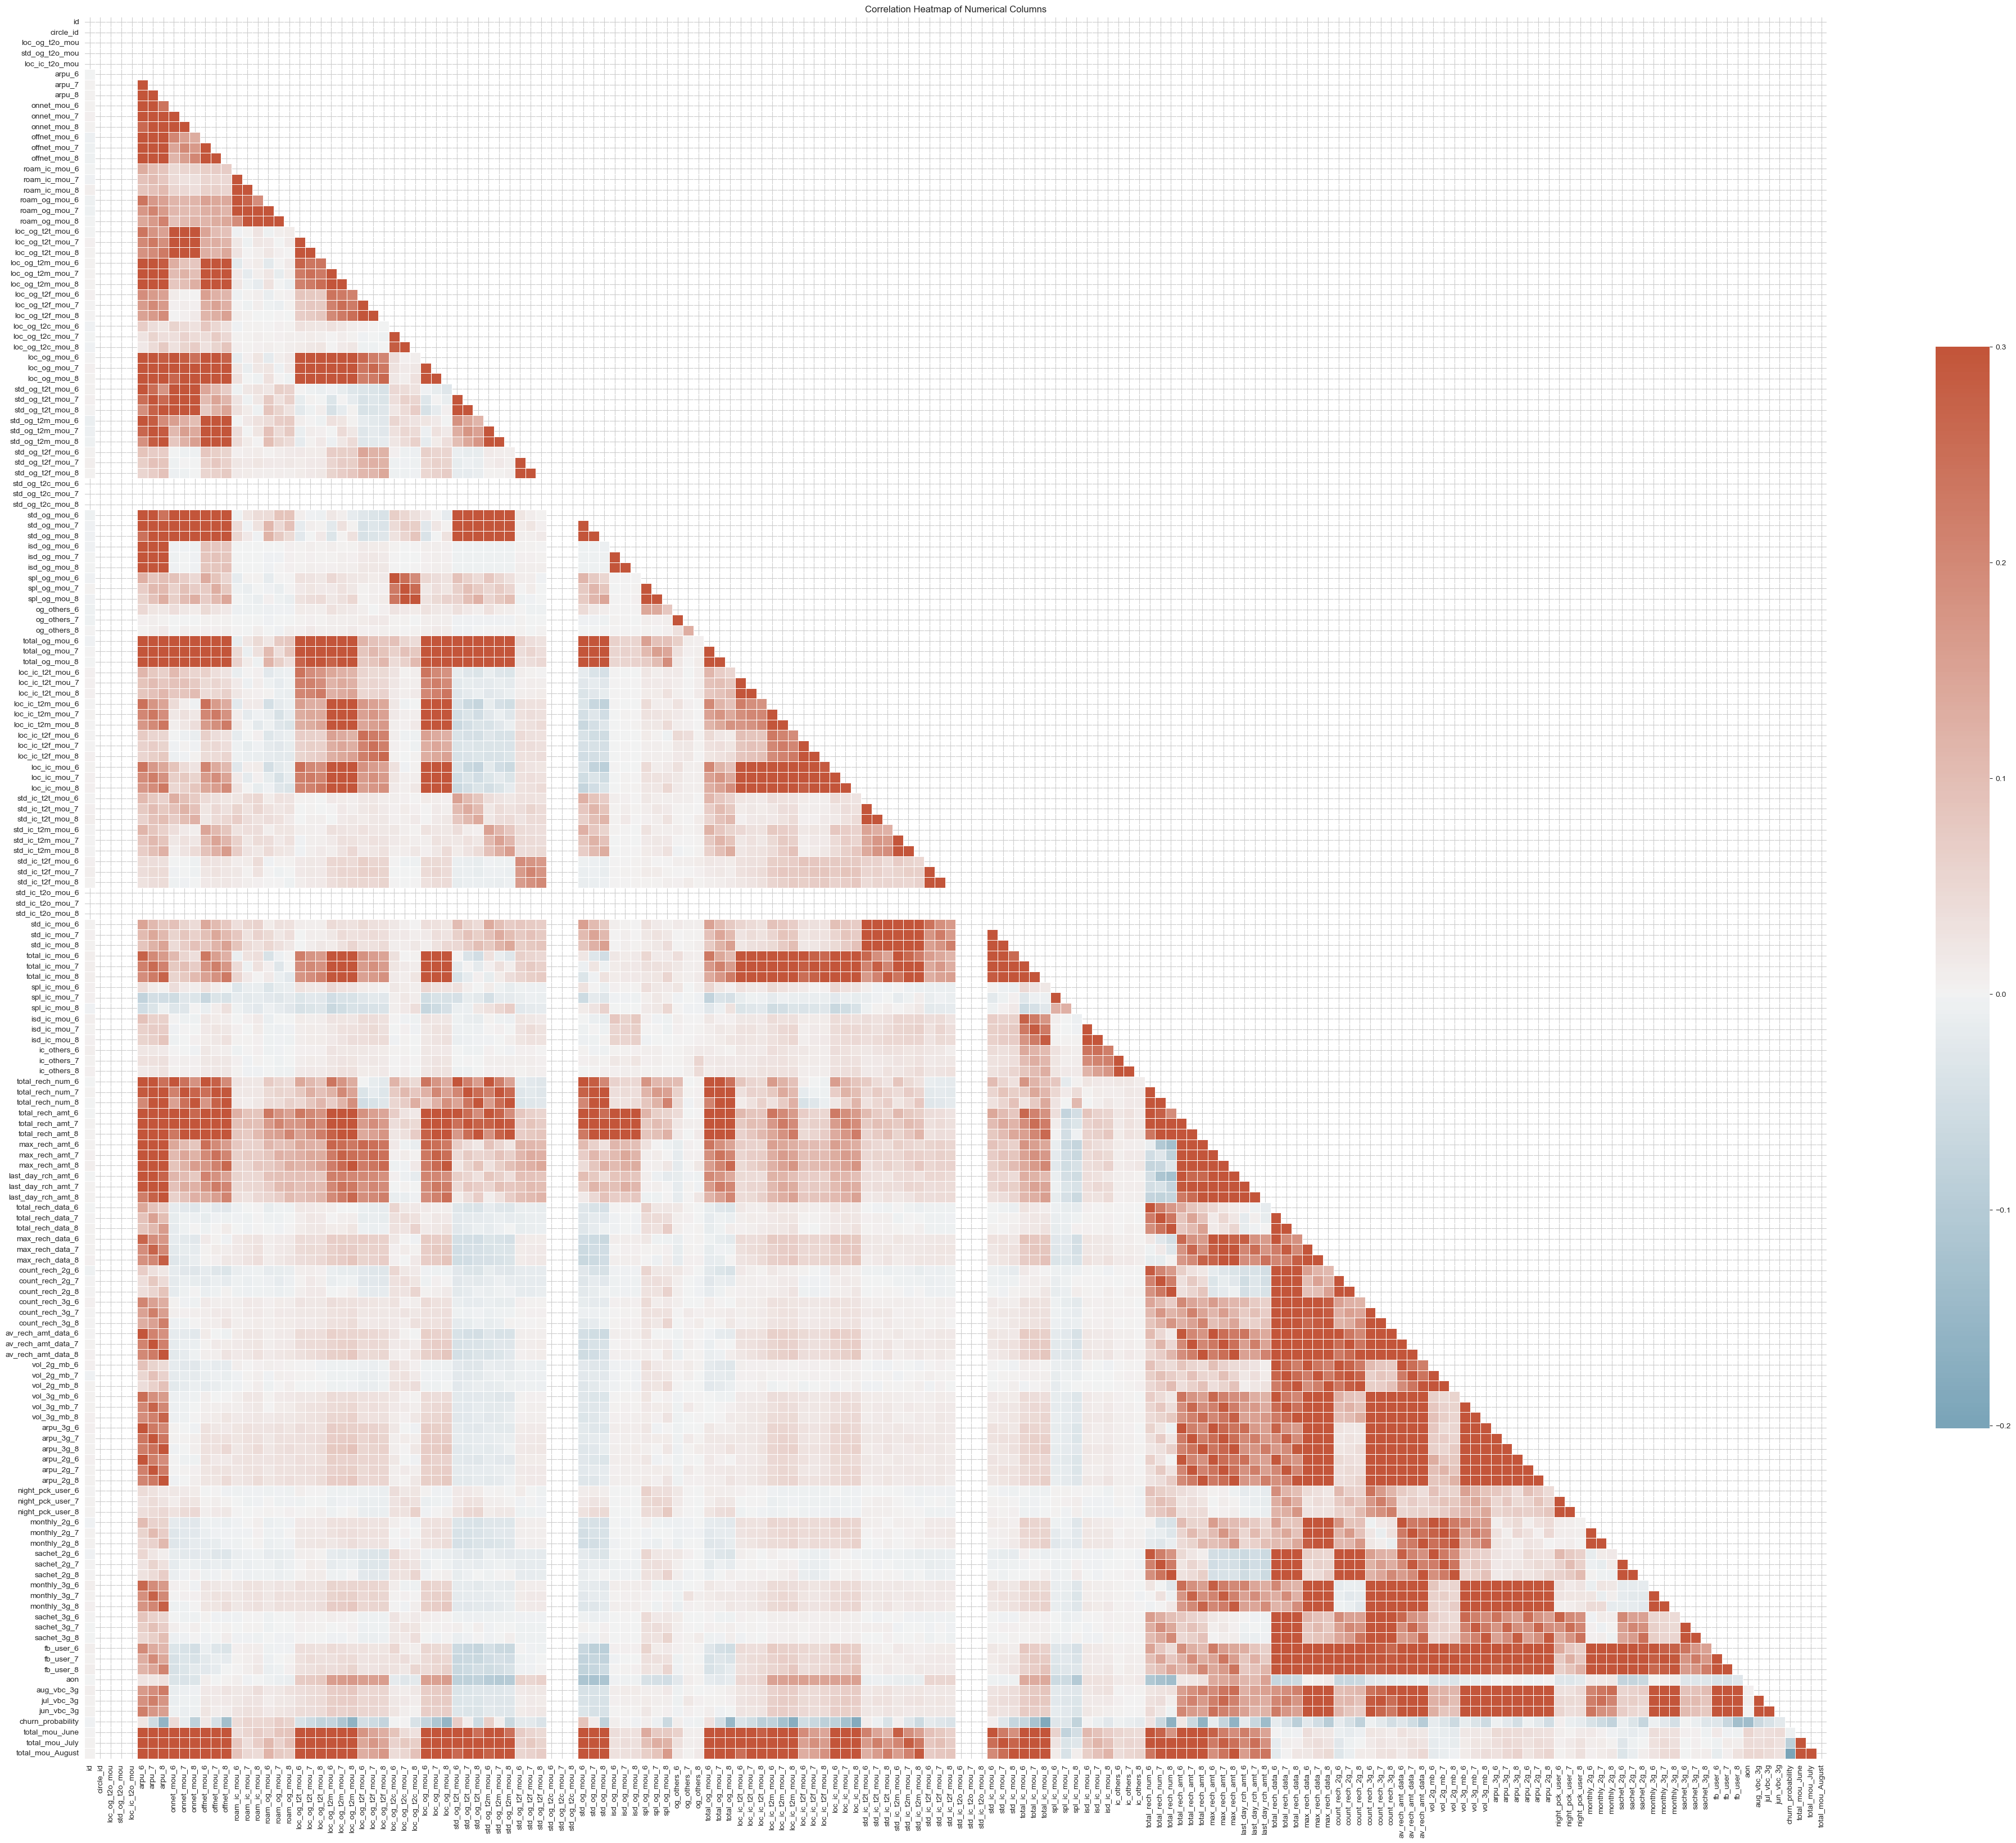

In [35]:
# Let us look at the correlation between the columns and plot it as heat map.
# Calculate correlations
numerical_columns = raw_data.select_dtypes(include=np.number).columns.tolist()
corr = raw_data[numerical_columns].corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

There are too many columns and not all of these columns are really useful. For example - if a customer has recharged within the month then whether they use 3g or 2g is irrelevant.
Similarly if a customer has not recharged within the month then whether they use 3g or 2g is irrelevant. So perhaps we can drop 2g/3g related columns. Let us look at the correlation between the 2g/3g related columns and the churn probability.


In [36]:
# Calculate the correlation with 'churn_probability' for all the columns and look at the top values.
correlations = raw_data[numerical_columns].apply(lambda x: x.corr(raw_data['churn_probability']))

# Sort in ascending order
correlations_asc = correlations.sort_values()

# Sort in descending order
correlations_desc = correlations.sort_values(ascending=False)

print("Correlations sorted in ascending order:\n", correlations_asc)
print("\nCorrelations sorted in descending order:\n", correlations_desc)


Correlations sorted in ascending order:
 total_mou_August   -0.201316
total_ic_mou_8     -0.187566
loc_ic_mou_8       -0.182085
loc_ic_t2m_mou_8   -0.176718
total_rech_num_8   -0.167043
                      ...   
std_og_t2c_mou_7         NaN
std_og_t2c_mou_8         NaN
std_ic_t2o_mou_6         NaN
std_ic_t2o_mou_7         NaN
std_ic_t2o_mou_8         NaN
Length: 166, dtype: float64

Correlations sorted in descending order:
 churn_probability    1.000000
std_og_mou_6         0.087780
std_og_t2t_mou_6     0.069426
roam_og_mou_7        0.068077
std_og_t2m_mou_6     0.066194
                       ...   
std_og_t2c_mou_7          NaN
std_og_t2c_mou_8          NaN
std_ic_t2o_mou_6          NaN
std_ic_t2o_mou_7          NaN
std_ic_t2o_mou_8          NaN
Length: 166, dtype: float64


In [43]:
# Let us only look at correlation between totals columns and churn probability
total_columns = [col for col in raw_data.columns if 'total' in col]
correlations = raw_data[total_columns].apply(lambda x: x.corr(raw_data['churn_probability']))
print(correlations.sort_values(ascending=False))

total_og_mou_6       0.033225
total_rech_num_6     0.025966
total_rech_amt_6     0.018869
total_mou_June      -0.005421
total_rech_data_6   -0.017259
total_rech_data_7   -0.045962
total_og_mou_7      -0.047588
total_rech_num_7    -0.062956
total_rech_amt_7    -0.063978
total_ic_mou_6      -0.070951
total_rech_data_8   -0.090536
total_mou_July      -0.091337
total_ic_mou_7      -0.120197
total_og_mou_8      -0.149325
total_rech_amt_8    -0.160455
total_rech_num_8    -0.167043
total_ic_mou_8      -0.187566
total_mou_August    -0.201316
dtype: float64


Let us look at correlation between all the numerical columns.


In [44]:
# Calculate the correlation matrix
corr_matrix = raw_data.corr()

# Create a DataFrame to store the highly correlated pairs
highly_correlated_pairs = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

# Define your threshold
threshold = 0.8

# Loop through the columns of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs = highly_correlated_pairs.append({'Feature 1': corr_matrix.columns[i],
                                                                      'Feature 2': corr_matrix.columns[j],
                                                                      'Correlation': corr_matrix.iloc[i, j]},
                                                                     ignore_index=True)

print(highly_correlated_pairs)


      Feature 1         Feature 2  Correlation
0        arpu_6  total_rech_amt_6     0.952776
1        arpu_7  total_rech_amt_7     0.955298
2        arpu_8  total_rech_amt_8     0.958333
3   onnet_mou_6  std_og_t2t_mou_6     0.855785
4   onnet_mou_7  std_og_t2t_mou_7     0.862664
..          ...               ...          ...
59    arpu_3g_8         arpu_2g_8     0.935173
60    arpu_3g_8      monthly_3g_8     0.836255
61    arpu_2g_6      monthly_3g_6     0.849265
62    arpu_2g_7      monthly_3g_7     0.851765
63    arpu_2g_8      monthly_3g_8     0.848269

[64 rows x 3 columns]


There are 64 pairs with correlation greater than 0.8. This sort of suggests that including all of these columns
doesn't make any sense. So let us drop some of these columns.


In [45]:
# Create a copy of the original dataframe
raw_data_copy = raw_data.copy()

# Drop the second feature from each correlated pair
for index, row in highly_correlated_pairs.iterrows():
    if row['Feature 2'] in raw_data_copy.columns:
        raw_data_copy = raw_data_copy.drop(columns=row['Feature 2'])

# raw_data_copy now holds the dataframe with the correlated features removed

print(raw_data_copy.shape)
print(raw_data.shape)
raw_data_copy.head()

(69999, 114)
(69999, 166)


,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_2g_7,monthly_2g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,...,0,0,0.0,0.0,0.0,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,...,0,0,0.0,1.0,0.0,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,...,0,0,0.0,0.0,0.0,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,...,0,0,0.0,0.0,0.0,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,...,0,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


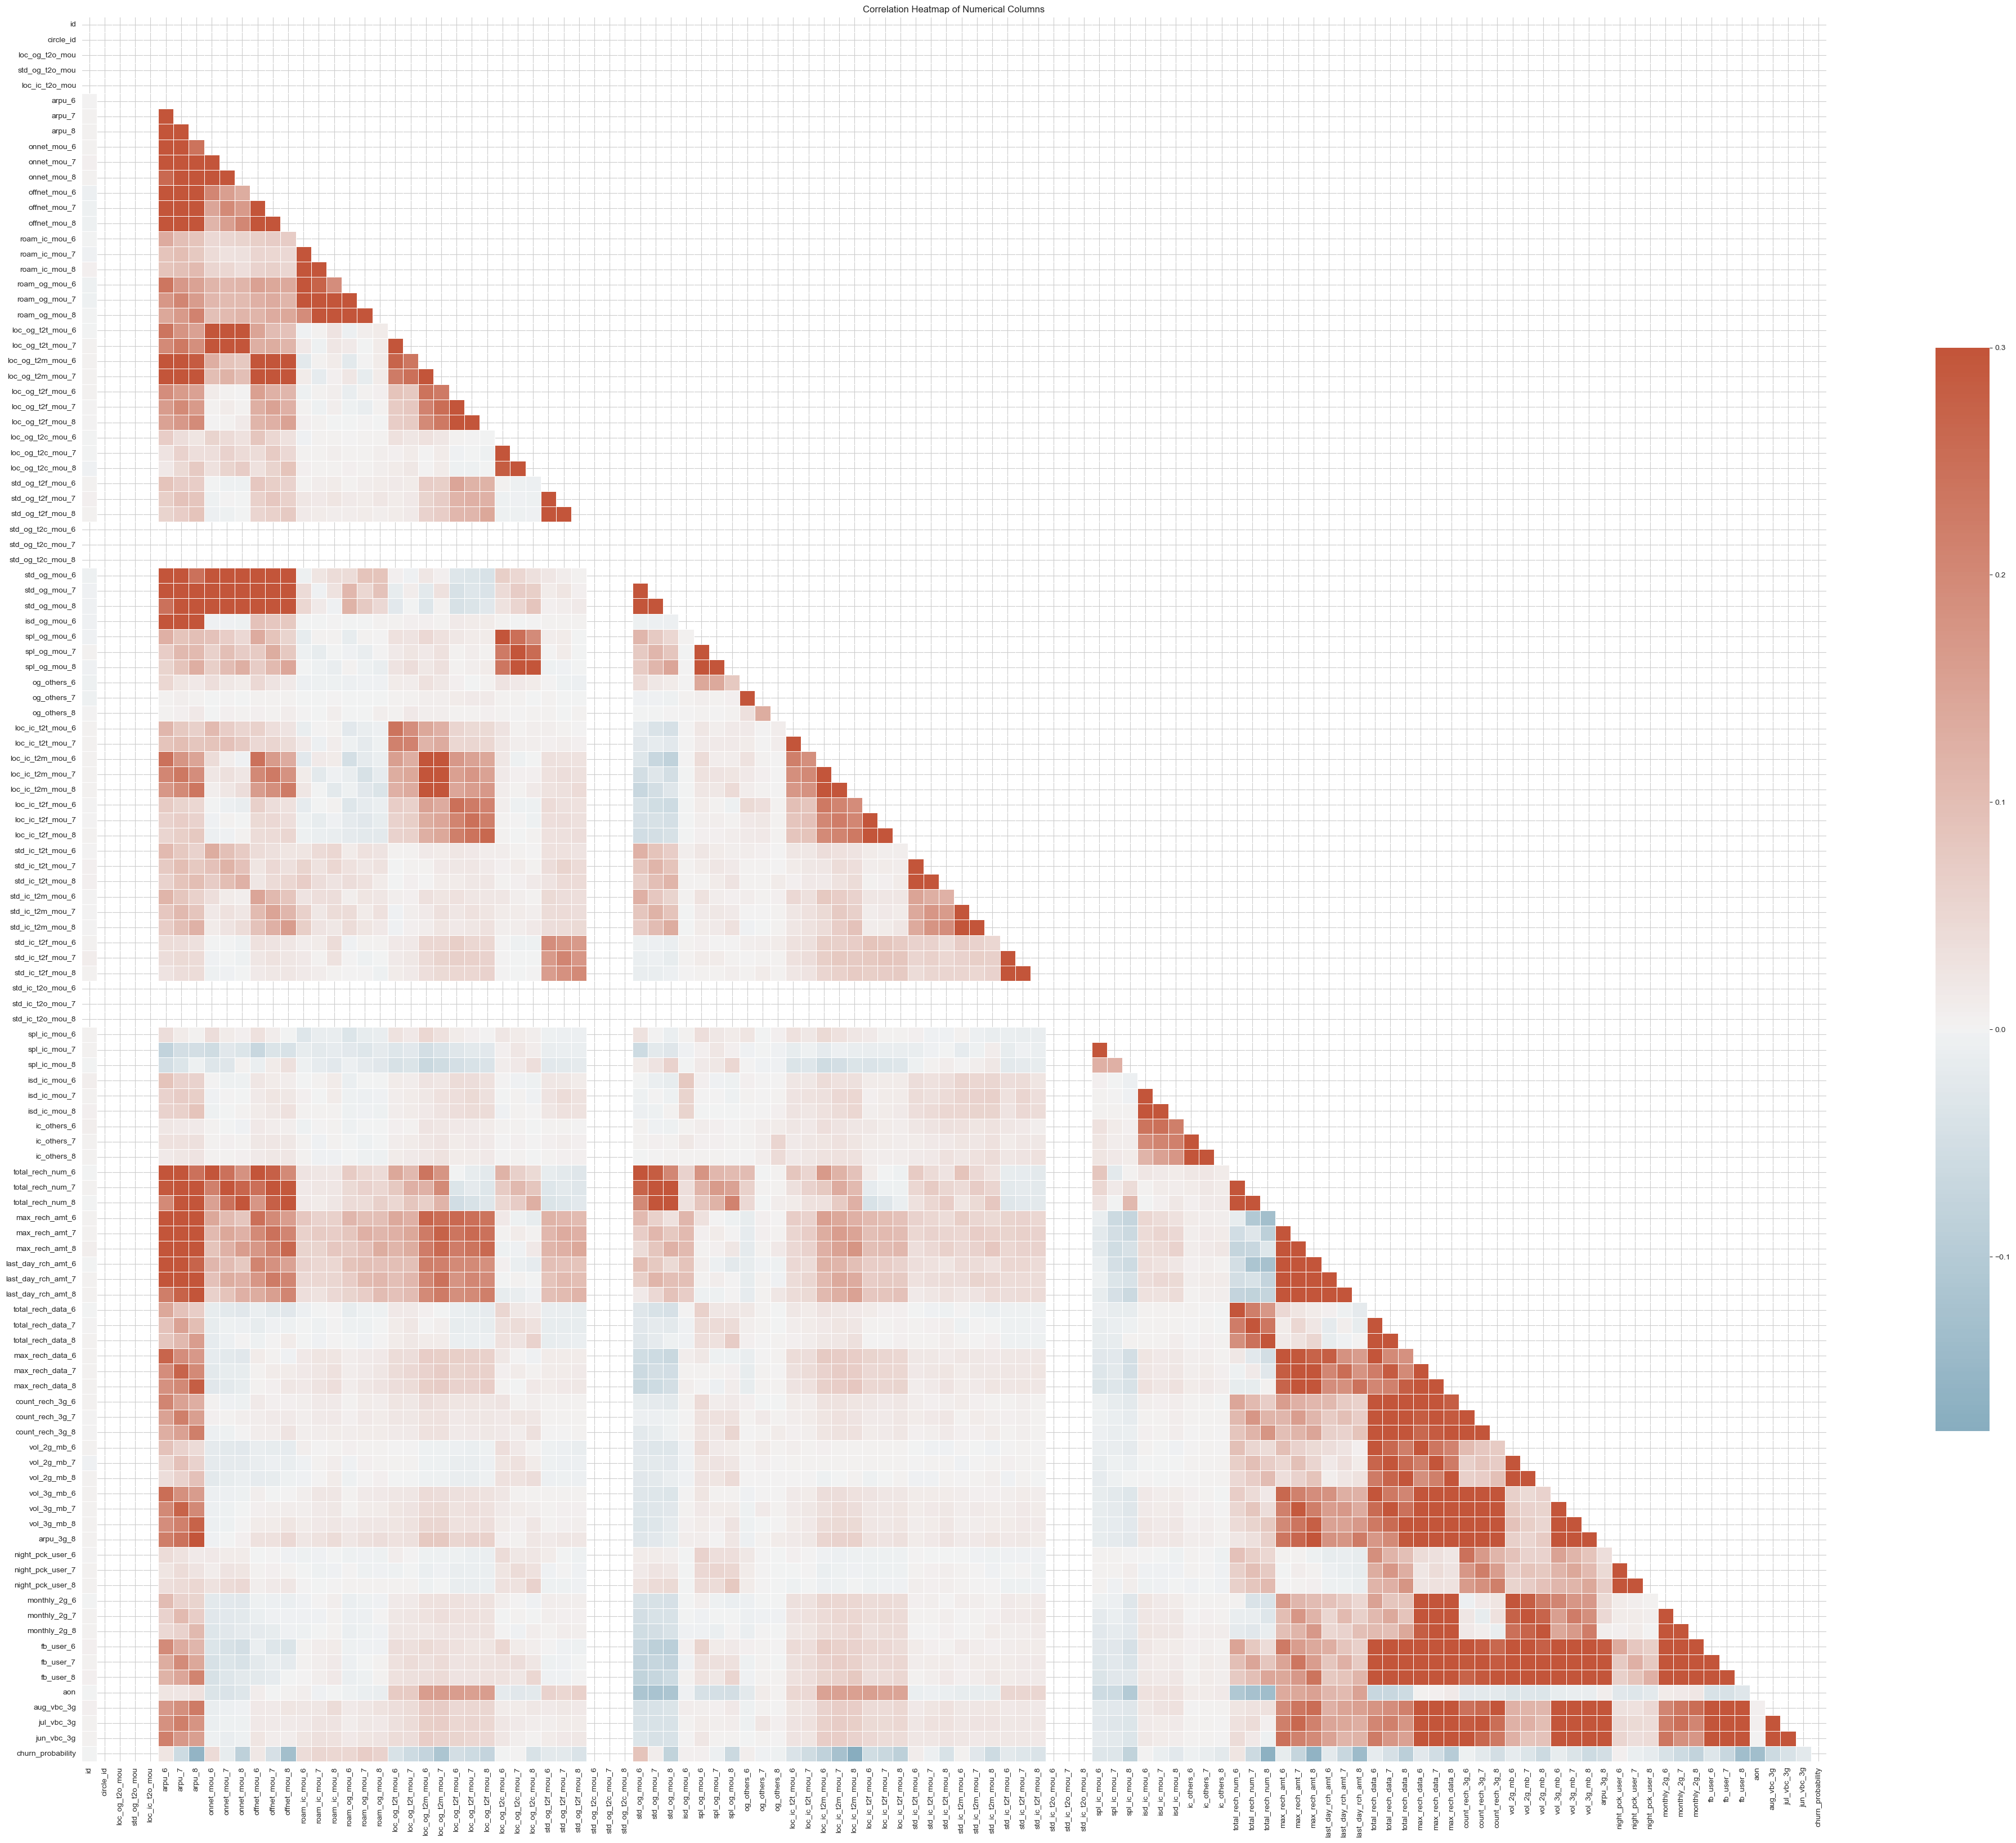

In [47]:
corr_matrix = raw_data_copy.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Numerical Columns')
plt.show()